## Imports

In [ ]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import spectral.io.envi as envi
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn.metrics import precision_recall_curve, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
# from sklearn.datasets import load_digits
from sklearn.model_selection import KFold, learning_curve, ShuffleSplit, GridSearchCV
# from yellowbrick.model_selection import RFECV
from time import time
# from sklearn.feature_selection import SequentialFeatureSelector
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras.layers.experimental import preprocessing
# from tensorflow.keras.callbacks import EarlyStopping
# from keras.models import Sequential
# from keras.layers import Dense

# print(tf.__version__)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


## Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Dataset

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/Thesis/mean_dataset/normalized/dataset_mean_normalized.csv', encoding='latin-1')
# dataset.head(3)
columns = dataset.iloc[:, 2:].columns.values

In [ ]:
X = np.load('/content/drive/MyDrive/Thesis/dataset/segmented_normalized_one_tenth/X.npy')

In [ ]:
y = np.load('/content/drive/MyDrive/Thesis/dataset/segmented_normalized_one_tenth/y.npy')

In [ ]:
X.shape

(841005, 186)

## learning curve based on number of samples

In [ ]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


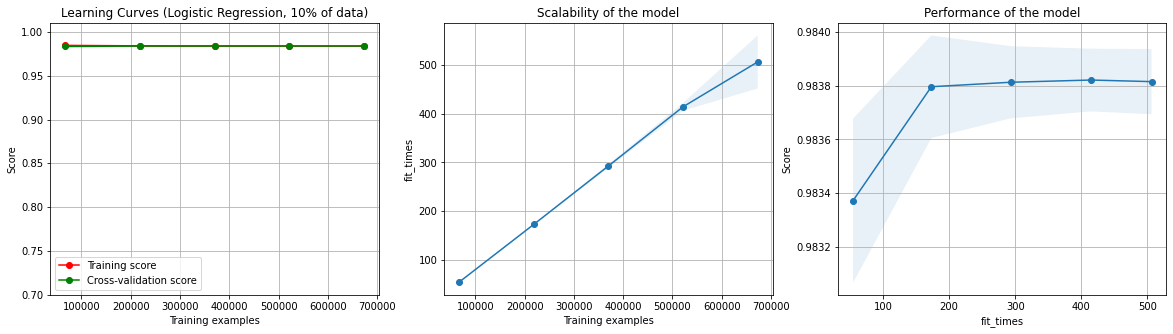

In [ ]:
title = r"Learning Curves (Logistic Regression, 10% of data)"

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
estimator = LogisticRegression(penalty='none', random_state=42, max_iter=1000)
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=-1)

plt.show()

#### only 1% of dataset

In [ ]:
X = X[::10, :]
y = y[::10]
X.shape

(84101, 186)

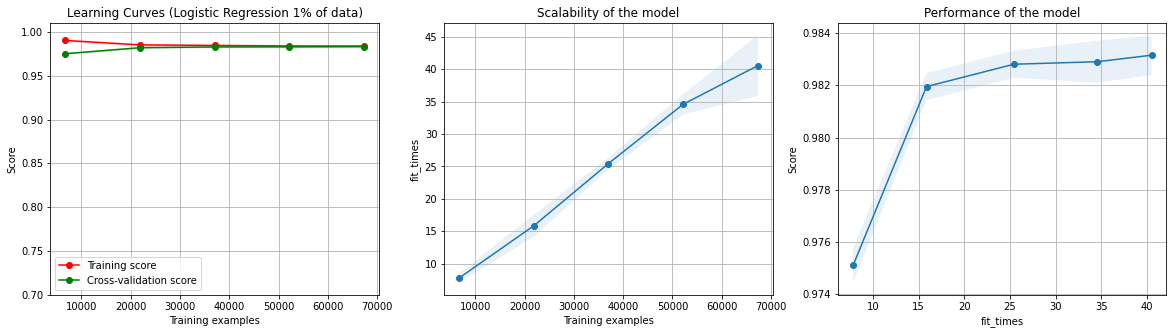

In [ ]:
title = r"Learning Curves (Logistic Regression 1% of data)"

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
estimator = make_pipeline(StandardScaler(), LogisticRegression(penalty='none', random_state=42, max_iter=100000))
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=-1)

plt.show()

#### only 0.1% of dataset

In [ ]:
X = X[::10, :]
y = y[::10]
X.shape

(8411, 186)

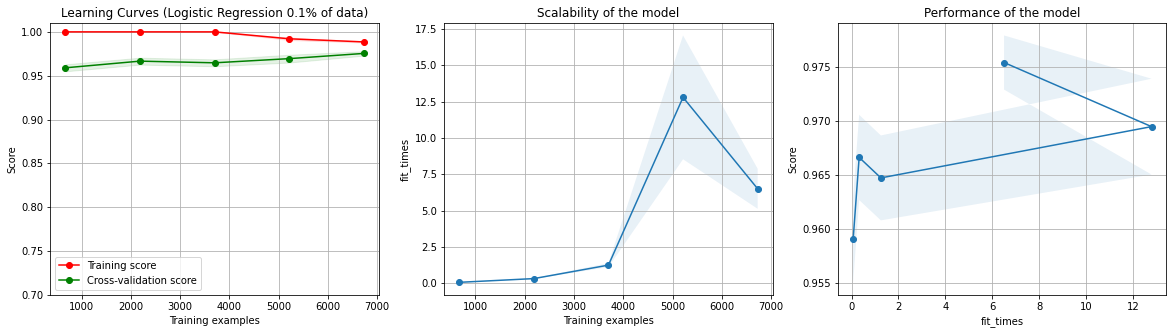

In [ ]:
title = r"Learning Curves (Logistic Regression 0.1% of data)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
estimator = make_pipeline(StandardScaler(), LogisticRegression(penalty='none', random_state=42, max_iter=100000))
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=-1)

plt.show()

## initiate instances of LR and FFS and run training

In [ ]:
X = X[::10, :]
y = y[::10]
X.shape

(84101, 186)

In [ ]:
clf = make_pipeline(StandardScaler(), LogisticRegression(penalty='none', max_iter=1000))

In [ ]:
%%time
sfs1 = sfs(clf, 
           k_features=100, 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='accuracy',
           cv=5,
           n_jobs=-1)

sfs1 = sfs1.fit(X, y, custom_feature_names=columns)

filename = '/content/drive/MyDrive/Thesis/results/wrappers/LR_wrapper.sav'
pickle.dump(sfs1, open(filename, 'wb'))

### pickle instance of FFS for later use due to colab time limits

In [ ]:
# save the wrapper file to drive
filename = '/content/drive/MyDrive/Thesis/results/wrappers/LR_wrapper.sav'
pickle.dump(sfs1, open(filename, 'wb'))

In [ ]:
# read the wrapper file from drive
filename = '/content/drive/MyDrive/Thesis/results/wrappers/SFS_LR.sav'
sfs1 = pickle.load(open(filename, 'rb'))

In [ ]:
sfs1.k_feature_idx_

(0,
 1,
 9,
 10,
 11,
 12,
 13,
 14,
 17,
 20,
 23,
 24,
 29,
 30,
 31,
 32,
 41,
 43,
 46,
 48,
 50,
 51,
 59,
 60,
 64,
 66,
 93,
 94,
 96,
 104,
 105,
 109,
 111,
 120,
 121,
 126,
 128,
 132,
 141,
 148,
 149,
 150,
 151,
 153,
 155,
 158,
 159,
 161,
 166,
 167,
 168,
 169,
 174,
 175,
 181,
 184)

In [ ]:
sfs1.k_feature_names_

('Band_001',
 'Band_002',
 'Band_010',
 'Band_011',
 'Band_012',
 'Band_013',
 'Band_014',
 'Band_015',
 'Band_018',
 'Band_021',
 'Band_024',
 'Band_025',
 'Band_030',
 'Band_031',
 'Band_032',
 'Band_033',
 'Band_042',
 'Band_044',
 'Band_047',
 'Band_049',
 'Band_051',
 'Band_052',
 'Band_060',
 'Band_061',
 'Band_065',
 'Band_067',
 'Band_094',
 'Band_095',
 'Band_097',
 'Band_105',
 'Band_106',
 'Band_110',
 'Band_112',
 'Band_121',
 'Band_122',
 'Band_127',
 'Band_129',
 'Band_133',
 'Band_142',
 'Band_149',
 'Band_150',
 'Band_151',
 'Band_152',
 'Band_154',
 'Band_156',
 'Band_159',
 'Band_160',
 'Band_162',
 'Band_167',
 'Band_168',
 'Band_169',
 'Band_170',
 'Band_175',
 'Band_176',
 'Band_182',
 'Band_185')

In [ ]:
sfs1.k_score_

0.9589064063443148

In [ ]:
df_result = pd.DataFrame.from_dict(sfs1.get_metric_dict()).T
# df_result.to_csv('/content/drive/MyDrive/Thesis/models/LR_wrapper_one_percent.csv')
df_result

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(12,)","[0.7278996492479639, 0.6664684898929846, 0.695...",0.711977,"(Band_013,)",0.0435374,0.0338736,0.0169368
2,"(12, 93)","[0.8373461744248261, 0.6077883472057075, 0.674...",0.75062,"(Band_013, Band_094)",0.12791,0.0995184,0.0497592
3,"(12, 59, 93)","[0.9058319957196361, 0.8160523186682521, 0.870...",0.870405,"(Band_013, Band_060, Band_094)",0.0428124,0.0333095,0.0166548
4,"(12, 59, 93, 168)","[0.9245585874799358, 0.8532104637336504, 0.902...",0.905899,"(Band_013, Band_060, Band_094, Band_169)",0.037137,0.0288939,0.0144469
5,"(12, 32, 59, 93, 168)","[0.9332976636347423, 0.8819262782401902, 0.909...",0.918039,"(Band_013, Band_033, Band_060, Band_094, Band_...",0.02615,0.0203456,0.0101728
6,"(12, 32, 59, 93, 94, 168)","[0.9393615123952203, 0.8925089179548157, 0.904...",0.923722,"(Band_013, Band_033, Band_060, Band_094, Band_...",0.0273152,0.0212521,0.0106261
7,"(12, 32, 59, 64, 93, 94, 168)","[0.9397776588787825, 0.894114149821641, 0.9095...",0.927278,"(Band_013, Band_033, Band_060, Band_065, Band_...",0.0280415,0.0218172,0.0109086
8,"(12, 32, 43, 59, 64, 93, 94, 168)","[0.948992331014803, 0.889833531510107, 0.91718...",0.931891,"(Band_013, Band_033, Band_044, Band_060, Band_...",0.0318193,0.0247565,0.0123782
9,"(12, 32, 43, 59, 64, 66, 93, 94, 168)","[0.9530348968551215, 0.8929250891795482, 0.924...",0.933651,"(Band_013, Band_033, Band_044, Band_060, Band_...",0.0298774,0.0232456,0.0116228
10,"(12, 30, 32, 43, 59, 64, 66, 93, 94, 168)","[0.9539266393198977, 0.8976813317479192, 0.928...",0.936196,"(Band_013, Band_031, Band_033, Band_044, Band_...",0.0278856,0.021696,0.010848


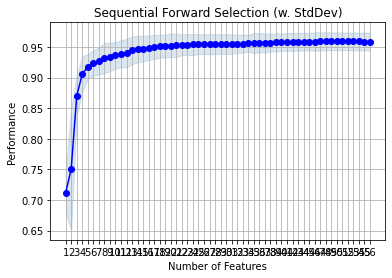

In [ ]:
fig1 = plot_sfs(sfs1.get_metric_dict(), kind='std_dev')

# plt.ylim([0, 1])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

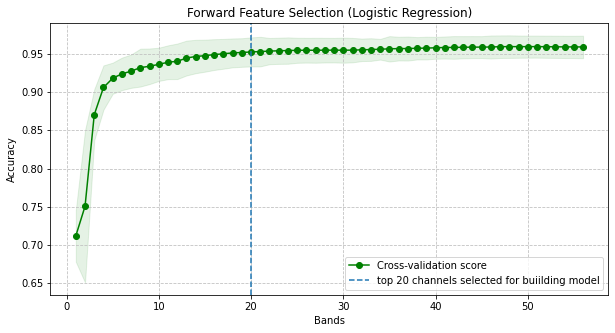

In [ ]:
plt.figure(figsize=(10, 5))
steps = np.arange(56) + 1

upper_bound = np.array(df_result.avg_score.values + df_result.std_dev.values, dtype='float32')
lower_bound = np.array(df_result.avg_score.values - df_result.std_dev.values, dtype='float32')
plt.fill_between(steps, upper_bound, lower_bound, alpha=0.1, color="g")

plt.plot(steps, df_result.avg_score, 'o-', color="g", label="Cross-validation score")

# plt.axvline(x=df_result.avg_score.values.argmax() + 1, ls='--', label='n_features = {}, Score = {}'.format(df_result.avg_score.values.argmax()+1, round(df_result.avg_score.values.max(), 2)))
plt.axvline(x=20, ls='--', label='top 20 channels selected for buiilding model')


plt.xlabel("Bands")
plt.ylabel("Accuracy")
plt.title("Forward Feature Selection (Logistic Regression)")
plt.grid(b=True, which='major', color='silver', linestyle='--')
plt.legend(loc="best")
plt.show()

In [ ]:
# ordered list of selected bands
ordered_list = list(set(df_result.feature_names.values[0]))
for i in range(20):
  band = list(set(df_result.feature_names.values[i+1]) - set(df_result.feature_names.values[i]))
  ordered_list.append(band[0])

ordered_list

['Band_013',
 'Band_094',
 'Band_060',
 'Band_169',
 'Band_033',
 'Band_095',
 'Band_065',
 'Band_044',
 'Band_067',
 'Band_031',
 'Band_014',
 'Band_110',
 'Band_105',
 'Band_129',
 'Band_106',
 'Band_097',
 'Band_175',
 'Band_122',
 'Band_176',
 'Band_015',
 'Band_121']

In [ ]:
# sorted list of selected bands
sorted_list = list(df_result.feature_names[len(df_result.feature_names)])
sorted_list

['Band_001',
 'Band_002',
 'Band_010',
 'Band_011',
 'Band_012',
 'Band_013',
 'Band_014',
 'Band_015',
 'Band_018',
 'Band_021',
 'Band_024',
 'Band_025',
 'Band_030',
 'Band_031',
 'Band_032',
 'Band_033',
 'Band_042',
 'Band_044',
 'Band_047',
 'Band_049',
 'Band_051',
 'Band_052',
 'Band_060',
 'Band_061',
 'Band_065',
 'Band_067',
 'Band_094',
 'Band_095',
 'Band_097',
 'Band_105',
 'Band_106',
 'Band_110',
 'Band_112',
 'Band_121',
 'Band_122',
 'Band_127',
 'Band_129',
 'Band_133',
 'Band_142',
 'Band_149',
 'Band_150',
 'Band_151',
 'Band_152',
 'Band_154',
 'Band_156',
 'Band_159',
 'Band_160',
 'Band_162',
 'Band_167',
 'Band_168',
 'Band_169',
 'Band_170',
 'Band_175',
 'Band_176',
 'Band_182',
 'Band_185']

### all in one

In [ ]:
# read the wrapper file from drive
filename = '/content/drive/MyDrive/Thesis/results/wrappers/'
sfs_lr = pickle.load(open(filename + 'SFS_LR.sav', 'rb'))
sfs_rf = pickle.load(open(filename + 'SFS_RF.sav', 'rb'))
sfs_svm = pickle.load(open(filename + 'SFS_SVM.sav', 'rb'))

In [ ]:
df_lr = pd.DataFrame.from_dict(sfs_lr.get_metric_dict()).T
df_rf = pd.DataFrame.from_dict(sfs_rf.get_metric_dict()).T
df_svm = pd.DataFrame.from_dict(sfs_svm.get_metric_dict()).T

In [ ]:
# lr_train_scores_mean_arr = df_lr.avg_score.values
# lr_train_scores_std_arr = df_lr.std_dev.values
lr_val_scores_mean_arr = df_lr.avg_score.values
lr_val_scores_std_arr = df_lr.std_dev.values

# rf_train_scores_mean_arr = df_rf.train_scores_mean.values
# rf_train_scores_std_arr = df_rf.train_scores_std.values
rf_val_scores_mean_arr = df_rf.avg_score.values
rf_val_scores_std_arr = df_rf.std_dev.values

# svm_train_scores_mean_arr = df_svm.train_scores_mean.values
# svm_train_scores_std_arr = df_svm.train_scores_std.values
svm_val_scores_mean_arr = df_svm.avg_score.values
svm_val_scores_std_arr = df_svm.std_dev.values

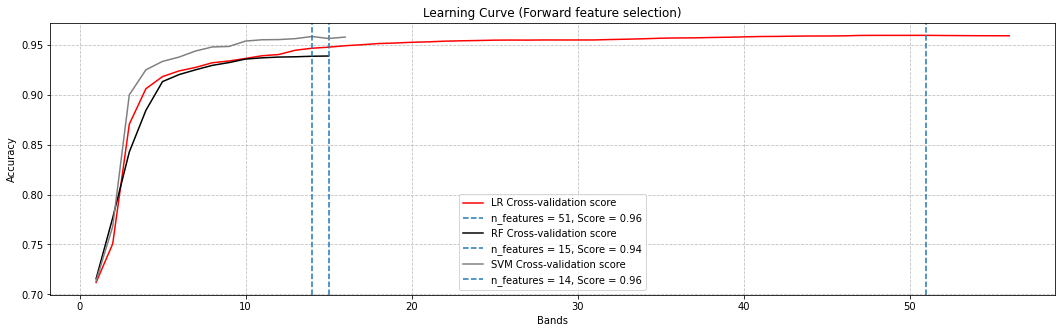

In [ ]:
steps_lr = np.arange(len(lr_val_scores_mean_arr)) + 1
steps_rf = np.arange(len(rf_val_scores_mean_arr)) + 1
steps_svm = np.arange(len(svm_val_scores_mean_arr)) + 1

plt.figure(figsize=(18, 5))

# logistic regression
# plt.fill_between(steps_lr, lr_train_scores_mean_arr - lr_train_scores_std_arr,
#                  lr_train_scores_mean_arr + lr_train_scores_std_arr, alpha=0.1, color="green")
# plt.fill_between(steps_lr, lr_val_scores_mean_arr - lr_val_scores_std_arr,
#                  lr_val_scores_mean_arr + lr_val_scores_std_arr, alpha=0.1, color="red")
# plt.plot(steps_lr, lr_train_scores_mean_arr, '--', color="green", label="LR Training score")
plt.plot(steps_lr, lr_val_scores_mean_arr, '-', color="red", label="LR Cross-validation score")
plt.axvline(x=lr_val_scores_mean_arr.argmax() + 1, ls='--', label='n_features = {}, Score = {}'.format(lr_val_scores_mean_arr.argmax()+1, round(lr_val_scores_mean_arr.max(), 2)))

# random forest
# plt.fill_between(steps_rf, rf_train_scores_mean_arr - rf_train_scores_std_arr,
#                  rf_train_scores_mean_arr + rf_train_scores_std_arr, alpha=0.1, color="blue")
# plt.fill_between(steps_rf, rf_val_scores_mean_arr - rf_val_scores_std_arr,
#                  rf_val_scores_mean_arr + rf_val_scores_std_arr, alpha=0.1, color="black")
# plt.plot(steps_rf, rf_train_scores_mean_arr, '--', color="blue", label="RF Training score")
plt.plot(steps_rf, rf_val_scores_mean_arr, '-', color="black", label="RF Cross-validation score")
plt.axvline(x=rf_val_scores_mean_arr.argmax() + 1, ls='--', label='n_features = {}, Score = {}'.format(rf_val_scores_mean_arr.argmax()+1, round(rf_val_scores_mean_arr.max(), 2)))

# svm
# plt.fill_between(steps_svm, svm_train_scores_mean_arr - svm_train_scores_std_arr,
#                  svm_train_scores_mean_arr + svm_train_scores_std_arr, alpha=0.1, color="orange")
# plt.fill_between(steps_svm, svm_val_scores_mean_arr - svm_val_scores_std_arr,
#                  svm_val_scores_mean_arr + svm_val_scores_std_arr, alpha=0.1, color="gray")
# plt.plot(steps_svm, svm_train_scores_mean_arr, '--', color="orange", label="SVM Training score")
plt.plot(steps_svm, svm_val_scores_mean_arr, '-', color="gray", label="SVM Cross-validation score")
plt.axvline(x=svm_val_scores_mean_arr.argmax() + 1, ls='--', label='n_features = {}, Score = {}'.format(svm_val_scores_mean_arr.argmax()+1, round(svm_val_scores_mean_arr.max(), 2)))


plt.xlabel("Bands")
plt.ylabel("Accuracy")
plt.title("Learning Curve (Forward feature selection)")
plt.grid(b=True, which='major', color='silver', linestyle='--')
plt.legend(loc="best")
plt.show()

## Grid Search CV for tuning hyper parameters of LR

In [ ]:
top_list = 13
selected_fatures = []
selected_fatures_idx = []

# df_result.feature_names[top_list][10]
for i in range(top_list):
  selected_fatures.append(df_result.feature_names[top_list][i])
  selected_fatures_idx.append(df_result.feature_idx[top_list][i])

selected_fatures

['Band_013',
 'Band_014',
 'Band_031',
 'Band_033',
 'Band_044',
 'Band_060',
 'Band_065',
 'Band_067',
 'Band_094',
 'Band_095',
 'Band_105',
 'Band_110',
 'Band_169']

In [ ]:
# X = np.load('/content/drive/MyDrive/Thesis/dataset/segmented_normalized_one_tenth/X.npy')
# y = np.load('/content/drive/MyDrive/Thesis/dataset/segmented_normalized_one_tenth/y.npy')

In [ ]:
X = X[::10, :]
y = y[::10]

In [ ]:
df = pd.DataFrame(data=X, columns=columns)
df.head(2)

,Band_001,Band_002,Band_003,Band_004,Band_005,Band_006,Band_007,Band_008,Band_009,Band_010,Band_011,Band_012,Band_013,Band_014,Band_015,Band_016,Band_017,Band_018,Band_019,Band_020,Band_021,Band_022,Band_023,Band_024,Band_025,Band_026,Band_027,Band_028,Band_029,Band_030,Band_031,Band_032,Band_033,Band_034,Band_035,Band_036,Band_037,Band_038,Band_039,Band_040,...,Band_147,Band_148,Band_149,Band_150,Band_151,Band_152,Band_153,Band_154,Band_155,Band_156,Band_157,Band_158,Band_159,Band_160,Band_161,Band_162,Band_163,Band_164,Band_165,Band_166,Band_167,Band_168,Band_169,Band_170,Band_171,Band_172,Band_173,Band_174,Band_175,Band_176,Band_177,Band_178,Band_179,Band_180,Band_181,Band_182,Band_183,Band_184,Band_185,Band_186
0,0.055364,0.071277,0.062560,0.062931,0.073905,0.055737,0.062921,0.060123,0.056552,0.062749,0.059414,0.059066,0.066134,0.064663,0.062497,0.063313,0.062573,0.063923,0.072067,0.061628,0.068952,0.069534,0.063854,0.063532,0.063523,0.063333,0.066438,0.065995,0.068486,0.067091,0.065591,0.069869,0.071611,0.071547,0.075075,0.079294,0.077710,0.074765,0.081016,0.080989,...,0.256003,0.244539,0.252226,0.255288,0.258960,0.255068,0.257223,0.266414,0.260323,0.269098,0.268707,0.262175,0.269845,0.263428,0.276127,0.277523,0.279097,0.271806,0.286093,0.284609,0.276917,0.290901,0.271737,0.296084,0.287388,0.288105,0.297305,0.287817,0.293130,0.280577,0.294222,0.307158,0.299976,0.291312,0.304959,0.295205,0.289494,0.300307,0.298140,0.306262
1,0.074993,0.072435,0.064133,0.080734,0.088216,0.070953,0.067431,0.068336,0.079696,0.081326,0.072144,0.064534,0.071140,0.076132,0.076926,0.073100,0.068827,0.075382,0.074642,0.074307,0.076571,0.078271,0.073199,0.074093,0.081167,0.073853,0.073868,0.075267,0.083201,0.082551,0.086952,0.093180,0.105580,0.112416,0.123468,0.129664,0.151454,0.161905,0.169379,0.175393,...,0.505026,0.494720,0.483715,0.488838,0.488722,0.487259,0.482478,0.480058,0.500768,0.489220,0.471241,0.482861,0.477204,0.484921,0.481572,0.477932,0.482379,0.469481,0.480970,0.455296,0.474330,0.453260,0.479589,0.466238,0.457954,0.463635,0.447302,0.468616,0.465824,0.460319,0.453349,0.457308,0.448119,0.459175,0.454227,0.460216,0.452923,0.471841,0.476259,0.469941


In [ ]:
df = df[selected_fatures]
df.head(2)

,Band_013,Band_014,Band_031,Band_033,Band_044,Band_060,Band_065,Band_067,Band_094,Band_095,Band_105,Band_110,Band_169
0,0.066134,0.064663,0.065591,0.071611,0.081628,0.092798,0.098142,0.094276,0.122954,0.135042,0.19498,0.194963,0.271737
1,0.071140,0.076132,0.086952,0.105580,0.197195,0.177255,0.170280,0.159244,0.252641,0.282450,0.48494,0.492199,0.479589


In [ ]:
df.shape

(84101, 13)

In [ ]:
clf = LogisticRegression(max_iter=1000000, random_state=42)

In [ ]:
param_grid = [{'C': [0.1, 0.3, 0.5, 0.7, 0.9, 1], 'solver': ['newton-cg', 'lbfgs', 'sag'], 'penalty': ['l2']},
              {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'penalty': ['none']}]

In [ ]:
grid_search = GridSearchCV(estimator = clf,
                           param_grid = param_grid,
                           scoring = 'accuracy',
                           cv = 5,
                           n_jobs = -1)
grid_search = grid_search.fit(df, y)

In [ ]:
best_estimator = grid_search.best_estimator_

In [ ]:
grid_search.best_score_

0.9445427792859288

In [ ]:
grid_search.best_params_

{'penalty': 'none', 'solver': 'sag'}

In [ ]:
# param_grid[0]['C']

[0.1, 0.3, 0.5, 0.7, 0.9, 1]

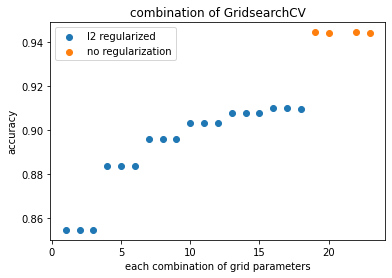

In [ ]:
plt.scatter(np.arange(18)+1,grid_search.cv_results_['mean_test_score'][:18], label='l2 regularized')
plt.scatter(np.arange(5)+19,grid_search.cv_results_['mean_test_score'][18:], label='no regularization')
plt.title('combination of GridsearchCV')
plt.xlabel('each combination of grid parameters')
plt.ylabel('accuracy')
plt.legend(loc='upper left')
plt.show()

In [ ]:
grid_search.cv_results_['mean_test_score']

array([0.85469799, 0.85466232, 0.85461476, 0.88362754, 0.88360376,
       0.88369889, 0.89601747, 0.89604125, 0.89601747, 0.90336583,
       0.90334205, 0.9034015 , 0.90780101, 0.90778912, 0.90775345,
       0.90988185, 0.90990564, 0.90975106, 0.94443576, 0.94440008,
              nan, 0.94454278, 0.94417418])

In [ ]:
grid_search.

<bound method BaseEstimator.get_params of GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=1000000, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'C': [0.1, 0.3, 0.5, 0.7, 0.9, 1], 'penalty': ['l2'],
                          'solver': ['newton-cg', 'lbfgs', 'sag']},
                         {'penalty': ['none'],
                          'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    

In [ ]:
gs_cv.cv_results_

{'mean_fit_time': array([0.00646253, 0.0062839 , 0.03547606, 0.01736193, 0.26972961,
        0.12502685, 0.26985936, 0.16969104]),
 'mean_score_time': array([0.00068617, 0.00072894, 0.00069218, 0.00074873, 0.00072308,
        0.00075555, 0.00075703, 0.00074983]),
 'mean_test_score': array([0.66829016, 0.68446139, 0.95054094, 0.93960158, 0.9497086 ,
        0.9497086 , 0.9497086 , 0.9497086 ]),
 'param_max_iter': masked_array(data=[1, 1, 10, 10, 100, 100, 1000, 1000],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_solver': masked_array(data=['newton-cg', 'lbfgs', 'newton-cg', 'lbfgs',
                    'newton-cg', 'lbfgs', 'newton-cg', 'lbfgs'],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_iter': 1, 'solver': 'newton-cg'},
  {'max_iter': 1, 'solver': 'lbfgs'},
  {'max_iter': 10, 'solver': 'newto

#### test

In [ ]:
# getting list of cropped reference images
source_file = '/content/drive/MyDrive/Thesis/source/VNIR_img.txt'
img_list = []
with open(source_file, "r") as listOfImages:
    for line in listOfImages:
        to_lower = str(line.strip()).lower() # make lower case to match reference imgs name
        img_list.append(to_lower)
        
print(len(img_list))

12


In [ ]:
ref = pd.read_csv('/content/drive/MyDrive/Thesis/files/img_labels.csv', encoding='latin-1')
ref.insert(loc=1, column='ref', value=img_list)
ref.head(3)

,Img_name,ref,PCR
0,Ind-AT1_V1-A_Blatt_VNIR,ind-at1_v1-a_blatt_vnir,1
1,Ind-AT1_V1-B_Blatt_VNIR,ind-at1_v1-b_blatt_vnir,1
2,Ind-AT1_V1-C_Blatt_VNIR,ind-at1_v1-c_blatt_vnir,1


In [ ]:
selected_fatures_idx

[12, 13, 30, 32, 43, 59, 64, 66, 93, 94, 104, 109, 168]

0
1
2
3
4
5
6
7
8
9
10
11


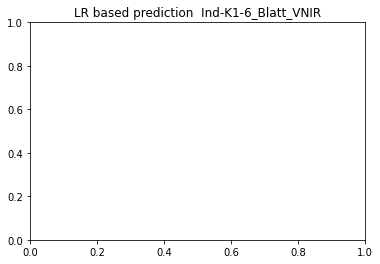

In [ ]:
for i in range(12):
  X_pre = np.zeros((2270, 1270, len(selected_fatures_idx)))
  img = np.load('/content/drive/MyDrive/Thesis/cropped_imgs/'+ ref.Img_name[i] +'.npy')
  for ch in range(len(selected_fatures_idx)):
    X_pre[:, :, ch:ch+1] = img[:, :, selected_fatures_idx[ch]:selected_fatures_idx[ch]+1]

  X_pre = X_pre.reshape(2270 * 1270, len(selected_fatures_idx))
  predicted = clf.predict(X_pre)
  predicted = np.reshape(predicted, (2270, -1))

  ref_img = np.load('/content/drive/MyDrive/Thesis/reference_img/cropped/'+ str(ref.ref[i]) +'.npy')
  ref_img[ref_img>0] = 1

  predicted_ref = predicted * ref_img
  predicted_ref = predicted_ref.reshape(2270, 1270, 1)

  rgb = np.zeros([2270, 1270, 3])
  rgb[:, :, 0:1] = img[:,:, 45:46].reshape((2270, 1270, 1)) + predicted_ref
  rgb[:, :, 1:2] = img[:,:, 120:121].reshape((2270, 1270, 1))
  rgb[:, :, 2:3] = img[:,:, 76:77].reshape((2270, 1270, 1))

  rgb = rgb / np.max(rgb)

  plt.title('LR based prediction  ' + ref.Img_name[i])
  plt.imsave('/content/drive/MyDrive/Thesis/predicted/FFS_LR_1percent_data_13bands/LR_predicted' + ref.Img_name[i] + '.png', rgb)

  print(i)

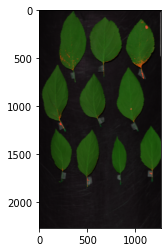

In [ ]:
plt.imshow(rgb)

In [ ]:
X = np.load('/content/drive/MyDrive/Thesis/dataset/segmented_normalized_original_size/X.npy')
y = np.load('/content/drive/MyDrive/Thesis/dataset/segmented_normalized_original_size/y.npy')

In [ ]:
df = pd.DataFrame(data=X, columns=columns)
df = df[selected_fatures]
df.head(2)

,Band_013,Band_014,Band_031,Band_033,Band_044,Band_060,Band_065,Band_067,Band_094,Band_095,Band_105,Band_110,Band_169
0,0.066134,0.064663,0.065591,0.071611,0.081628,0.092798,0.098142,0.094276,0.122954,0.135042,0.194980,0.194963,0.271737
1,0.054707,0.055160,0.068425,0.069881,0.093623,0.108971,0.104134,0.108792,0.154792,0.168122,0.251536,0.255374,0.337200


In [ ]:
from sklearn.metrics import plot_precision_recall_curve

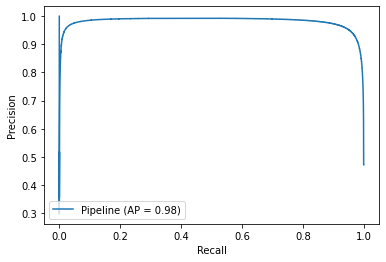

In [ ]:
disp = plot_precision_recall_curve(clf, df, y)

In [ ]:
print(classification_report(clf.predict(df), y))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96   4759476
           1       0.95      0.95      0.95   3650569

    accuracy                           0.96   8410045
   macro avg       0.96      0.96      0.96   8410045
weighted avg       0.96      0.96      0.96   8410045



In [ ]:
# restart runtime and clear ram
import os, signal
os.kill(os.getpid(), signal.SIGKILL)